# Running a GDS algorithm from Python

In [1]:
# hack to be able to import functions from utils
import sys
import os
sys.path.append(os.path.join(os.curdir, ".."))
# sys.path

In [2]:
from graphdatascience import GraphDataScience
from utils import create_projected_graph, plot_degree_distribution

In [3]:
gds = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "admin"))

In [4]:
projected_graph_object = create_projected_graph(
    gds,
    graph_name="persons",
    node_spec="Person",  
    relationship_spec={"KNOWS": {"orientation": "UNDIRECTED"}}
)
projected_graph_object

Graph({'graphName': 'persons', 'nodeCount': 40948, 'relationshipCount': 715412, 'database': 'neo4j', 'configuration': {'relationshipProjection': {'KNOWS': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'KNOWS', 'properties': {}}}, 'jobId': 'c6e093f2-d850-4483-ba8a-0fdac1912fad', 'nodeProjection': {'Person': {'label': 'Person', 'properties': {}}}, 'relationshipProperties': {}, 'creationTime': neo4j.time.DateTime(2022, 12, 18, 15, 35, 28, 662576097, tzinfo=<DstTzInfo 'Europe/Paris' CET+1:00:00 STD>), 'validateRelationships': False, 'readConcurrency': 4, 'sudo': False, 'nodeProperties': {}}, 'schema': {'graphProperties': {}, 'relationships': {'KNOWS': {}}, 'nodes': {'Person': {}}}, 'memoryUsage': '6286 KiB'})

## Degree algorithm in write mode

In [5]:
gds.degree.write(
    projected_graph_object,
    writeProperty="degree"
)

nodePropertiesWritten                                                 40948
centralityDistribution    {'p99': 111.00048065185547, 'min': 0.0, 'max':...
writeMillis                                                             348
postProcessingMillis                                                    165
preProcessingMillis                                                       0
computeMillis                                                             0
configuration             {'jobId': '0a87bd0e-0de6-4a72-a891-7341b70e55e...
Name: 0, dtype: object

In [6]:
degrees = gds.run_cypher("""
MATCH (n:Person)
RETURN id(n) as node_id, n.name as name, n.degree as degree
""")
degrees.head(10)

,node_id,name,degree
0,9046,Kirsten Johnson,0.0
1,9047,Julien Leclercq,24.0
2,9048,Mike Flanagan,33.0
3,9049,Robert Cullen,11.0
4,9050,José Luis Ucha,11.0
5,9051,Haile Gerima,8.0
6,9052,Andy Devonshire,4.0
7,9053,Theodore Melfi,11.0
8,9054,Kongkiat Komesiri,25.0
9,9055,Christian Schwochow,11.0


## Degree algorithm in stream mode

In [7]:
degrees = gds.degree.stream(
    projected_graph_object,
)
degrees

,nodeId,score
0,9046,0.0
1,9047,24.0
2,9048,33.0
3,9049,11.0
4,9050,11.0
...,...,...
40943,49989,9.0
40944,49990,8.0
40945,49991,8.0
40946,49992,8.0


In [8]:
row = degrees.iloc[1]
node = gds.util.asNode(row["nodeId"])
node.id

9047

In [9]:
type(node)

neo4j.graph.Node

In [10]:
degrees["id"] = [n.id for n in gds.util.asNodes(degrees['nodeId'].to_list())]
degrees.head()

,nodeId,score,id
0,9046,0.0,9046
1,9047,24.0,9047
2,9048,33.0,9048
3,9049,11.0,9049
4,9050,11.0,9050


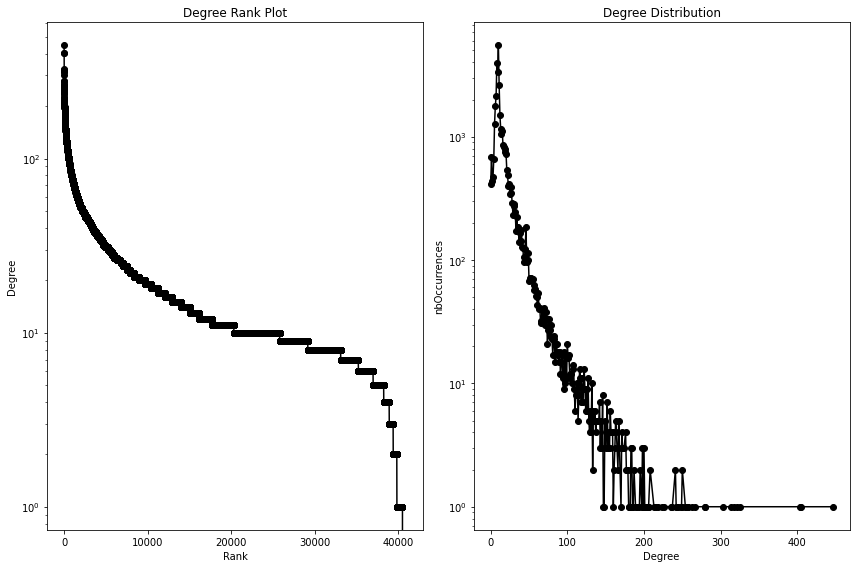

In [11]:
plot_degree_distribution(degrees.score);